# Table of Contents
 <p><div class="lev1"><a href="#Load-data-(pick-the-pairing-score-table-below!)"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load data (pick the pairing score table below!)</a></div><div class="lev1"><a href="#Define-plotting-functions"><span class="toc-item-num">2&nbsp;&nbsp;</span>Define plotting functions</a></div><div class="lev1"><a href="#Plot"><span class="toc-item-num">3&nbsp;&nbsp;</span>Plot</a></div><div class="lev2"><a href="#Batch-plot"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Batch plot</a></div>

In [1]:
%matplotlib inline
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import gridspec

import seaborn.apionly as sns
mpl.style.use('seaborn-talk')
pal = sns.palettes.get_color_cycle()

import numpy as np
import pandas as pd
import scipy.stats as st

import cooler
import bioframe

import cooltools
import cooltools.num.numutils

import pathlib

In [2]:
# add fall colormap
import matplotlib

def listToColormap(colorList, cmapName=None):
    colorList = np.array(colorList)
    if colorList.min() < 0:
        raise ValueError("Colors should be 0 to 1, or 0 to 255")
    if colorList.max() > 1.:
        if colorList.max() > 255:
            raise ValueError("Colors should be 0 to 1 or 0 to 255")
        else:
            colorList = colorList / 255.
    return matplotlib.colors.LinearSegmentedColormap.from_list(cmapName, colorList, 256)

fallList = [
     (255, 255, 255), (255, 255, 204),
     (255, 237, 160), (254, 217, 118),
     (254, 178, 76), (253, 141, 60),
     (252, 78, 42), (227, 26, 28),
     (189, 0, 38), (128, 0, 38), (0, 0, 0)]


def registerList(mylist, name):
    mymap = listToColormap(mylist, name)
    mymapR = listToColormap(mylist[::-1], name + "_r")
    mymapR.set_bad('white',1.)
    mymap.set_bad('white',1.)
    matplotlib.cm.register_cmap(name, mymap)
    matplotlib.cm.register_cmap(name + "_r", mymapR)

registerList(fallList, "fall")

coolwarm = matplotlib.cm.coolwarm
coolwarm.set_bad('white',1.)
matplotlib.cm.register_cmap('coolwarm', coolwarm)

def select_finite(z):
    return z[np.isfinite(z)]

def gridspec_inches(
    wcols,
    hrows,
    fig_kwargs={}):

    import matplotlib as mpl
    import matplotlib.pyplot as plt

    fig_height_inches = (
        sum(hrows)
        )

    fig_width_inches = (
        sum(wcols)
        )

    fig=plt.figure(
        figsize=(fig_width_inches,fig_height_inches),
        subplotpars=mpl.figure.SubplotParams(
        left=0,
        right=1,
        bottom=0,
        top=1,
        wspace =0,
        hspace = 0.0),
        frameon=False,
        **fig_kwargs)
    fig.set_size_inches(fig_width_inches,fig_height_inches,forward=True)

    gs = mpl.gridspec.GridSpec(
        len(hrows),
        len(wcols),
        left=0,
        right=1,
        top=1,
        bottom=0,
        wspace=0,
        hspace=0,
        width_ratios=wcols,
        height_ratios=hrows
        )

    return fig, gs


# Load data (pick the pairing score table below!)

In [3]:
dm3_chromsizes = bioframe.read_chromsizes(
    '/net/levsha/share/lab/genomes/dm3/dm3.chrom.sizes.higlass',
    all_names=True)


dm3_057_439_chromsizes = bioframe.read_chromsizes(
    '/net/levsha/share/lab/genomes/phased/dm3-057-439-JJ-snps-hybrid/dm3_057_439-JJ-snps-hybrid.chromsizes',
    all_names=True)

In [4]:
RES = 4000
pairing = pd.read_table(
    '/net/levsha/share/lab/DrosophilaWulab/tracks/pairing-057-439/tables/JJ17_18.log2_pairing.res_{}.win_24000.balance.nonorm.per_hom.nanmean.tsv'.format(RES),
    #'/net/levsha/share/lab/DrosophilaWulab/tracks/pairing-057-439/tables/JJ25_26.log2_pairing.res_4000.win_24000.balance.nonorm.per_hom.nanmean.tsv',
    comment='#'
    
)
eigs= pd.read_table(
    '/net/levsha/share/lab/DrosophilaWulab/tracks/eigs/dm3/JJ17_18.ciseigs.{}.clip_99.genedens_sort.tsv'.format(RES)
)

# Define plotting functions

In [5]:
def get_bin_data(bw_path, use_chrX=True):
    x = None
    y = None
    chroms = ['chr2L','chr2R','chr3L','chr3R']
    if use_chrX:
        chroms += ['chrX']
    for chrom in chroms:
        start = 0
        end = dm3_chromsizes[chrom]

        loc_pairing = bioframe.slice_bedframe(pairing, (chrom+'_057', start, end)).pairing.values

        loc_chip = bioframe.read_bigwig_binned(
            bw_path,
            chrom,
            start,
            end,
            int(np.ceil((end-start)/RES))
        )

        x = np.log10(loc_chip) if x is None else np.r_[x, np.log10(loc_chip)]
        y = loc_pairing        if y is None else np.r_[y, loc_pairing]

    return x,y

In [6]:
def golden_plot(x,y, show_quadrants=True, x_quadrant=None, y_quadrant=None):
    mask = np.isfinite(x) & np.isfinite(y)

    xspan = (np.percentile(x[mask],2.5), np.percentile(x[mask],97.5))
    yspan = (np.percentile(y[mask],2.5), np.percentile(y[mask],97.5))

    show_quadrants = True
    x_quadrant = (xspan[0] + (xspan[1] - xspan[0])/2) if x_quadrant is None else x_quadrant
    y_quadrant = (yspan[0] + (yspan[1] - yspan[0])/2) if y_quadrant is None else y_quadrant

    fig,gs =gridspec_inches(
        wcols = [1, 0.1, 3, 0.6, 0.5],
        hrows = [1, 0.1, 3]
    )


    plt.subplot(gs[(2,2)])
    _,_,_,hm = plt.hist2d(
        x[mask],
        y[mask],
        bins=50,
        cmap='fall',
        range=[xspan, yspan]
        )

    plt.gca().yaxis.tick_right()
    plt.gca().yaxis.set_label_position("right")

    plt.ylabel('log10 pairing score')
    plt.xlabel('log10 ChIP signal/input')
    if show_quadrants:
        plt.axvline(x_quadrant, ls='--', lw=1, color='gray')
        plt.axhline(y_quadrant, ls='--', lw=1, color='gray')    
        plt.text(
            xspan[0] + (xspan[1]-xspan[0]) * 0.05,
            yspan[0] + (yspan[1]-yspan[0]) * 0.9,
            '{:.2f}%'.format((mask & (x < x_quadrant) & (y >= y_quadrant)).sum() / mask.sum() * 100)
        )
        plt.text(
            xspan[0] + (xspan[1]-xspan[0]) * 0.7,
            yspan[0] + (yspan[1]-yspan[0]) * 0.9,
            '{:.2f}%'.format((mask & (x >= x_quadrant) & (y >= y_quadrant)).sum() / mask.sum() * 100)
        )
        plt.text(
            xspan[0] + (xspan[1]-xspan[0]) * 0.05,
            yspan[0] + (yspan[1]-yspan[0]) * 0.1,
            '{:.2f}%'.format((mask & (x < x_quadrant) & (y < y_quadrant)).sum() / mask.sum() * 100)
        )
        plt.text(
            xspan[0] + (xspan[1]-xspan[0]) * 0.7,
            yspan[0] + (yspan[1]-yspan[0]) * 0.1,
            '{:.2f}%'.format((mask & (x >= x_quadrant) & (y < y_quadrant)).sum() / mask.sum() * 100)
        )

    plt.subplot(gs[(2,4)])
    plt.axis('off')
    plt.colorbar(hm)

    plt.subplot(gs[(0,2)])
    _=plt.hist(x[mask], range=xspan, bins=50)
    plt.xticks([])
    sp = st.spearmanr(x[mask], y[mask])
    plt.title(f'r={sp.correlation:.3f}, p={sp.pvalue:.3e}')

    plt.subplot(gs[(2,0)])
    _=plt.hist(y[mask], range=yspan, bins=50,
               orientation='horizontal',)
    plt.xlim(plt.xlim()[1], plt.xlim()[0])
    plt.yticks([])



# Plot

In [7]:
# bw_path = '/net/levsha/share/lab/DrosophilaWulab/tracks/rnaseq/dm3/RNA__cells_jjwu2017.plus.all.bw'
# bw_path = '/net/levsha/share/lab/DrosophilaWulab/tracks/rnaseq/dm3/RNA__cells_jjwu2017.minus.all.bw'
#bw_path = '/net/levsha/share/lab/DrosophilaWulab/tracks/chip/bigwig/dm3/ChIP__H3K27ac_Kc__Kc167__LiCorces2015__VS__ChIP__Input_20HE_0hrs__Kc167__WoodCorces2011.fc.signal.bw'
#bw_path = '/net/levsha/share/lab/DrosophilaWulab/tracks/chip/bigwig/dm3/ChIP__H3K27me3__Kc167__CubenasPottsCorces2017__VS__ChIP__Histone3__Kc167__CubenasPottsCorces2017.fc.signal.bw'
#bw_path = '/net/levsha/share/lab/DrosophilaWulab/tracks/chip/bigwig/dm3/ChIP__Pc_RJ_NT__Kc167__LiCorces2015__VS__ChIP__IgG_NT__Kc167__LiCorces2015.fc.signal.bw'
bw_path = '/net/levsha/share/lab/DrosophilaWulab/tracks/chip/bigwig/dm3/ChIP__RNAPII_NT__Kc167__LiCorces2015__VS__ChIP__IgG_NT__Kc167__LiCorces2015.fc.signal.bw'
# bw_path = '/net/levsha/share/lab/DrosophilaWulab/tracks/chip/bigwig/dm3/ChIP__H3K4me1_Kc__Kc167__LiCorces2015__VS__ChIP__Input_20HE_0hrs__Kc167__WoodCorces2011.fc.signal.bw'
# bw_path = '/net/levsha/share/lab/DrosophilaWulab/tracks/chip/bigwig/dm3/ChIP__H3K4me3_NT__Kc167__LiCorces2015__VS__ChIP__Histone3__Kc167__CubenasPottsCorces2017.fc.signal.bw'
#bw_path = '/net/levsha/share/lab/DrosophilaWulab/tracks/chip/bigwig/dm3/ChIP__Trl_E0-8h__Embryo__NegreWhite2011__VS__ChIP__Trl_E0-8h_INPUT__Embryo__NegreWhite2011.fc.signal.bw'
#bw_path = '/net/levsha/share/lab/DrosophilaWulab/tracks/chip/bigwig/dm3/ChIP__2-3h_wt_Zld__Embryo__SunRushlow2015__VS__ChIP__2-3h_wt_Zld_input__Embryo__SunRushlow2015.fc.signal.bw'
#bw_path = '/net/levsha/share/lab/DrosophilaWulab/tracks/chip/bigwig/dm3/ChIP__wt_Bcd_E1-3__Embryo__XuSmall2014__VS__ChIP__wt_input__Embryo__XuSmall2014.fc.signal.bw'
#bw_path = '/net/levsha/share/lab/DrosophilaWulab/tracks/chip/bigwig/dm3/ChIP__2-3h_wt_Dl__Embryo__SunRushlow2015__VS__ChIP__2-3h_wt_Dl_input__Embryo__SunRushlow2015.fc.signal.bw'
#bw_path = '/net/levsha/share/lab/DrosophilaWulab/tracks/chip/bigwig/dm3/ChIP__2-3h_wt_Pol_II__Embryo__SunRushlow2015__VS__ChIP__2-3h_wt_Pol_II_input__Embryo__SunRushlow2015.fc.signal.bw'

/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

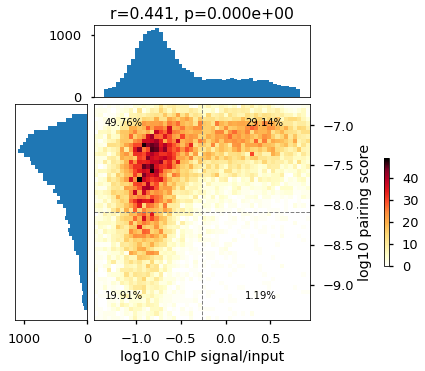

In [8]:
x,y = get_bin_data(bw_path=bw_path, use_chrX=False)
golden_plot(x,y, show_quadrants=True, x_quadrant=None, y_quadrant=None)


## Batch plot

/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in less
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in greater_equal
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher

pairing__vs__ChIP__H3K4me1_Kc__Kc167__LiCorces2015__VS__ChIP__Input_20HE_0hrs__Kc167__WoodCorces2011


FileNotFoundError: [Errno 2] No such file or directory: './pick/your/folder//pairing__vs__ChIP__H3K4me1_Kc__Kc167__LiCorces2015__VS__ChIP__Input_20HE_0hrs__Kc167__WoodCorces2011.png'

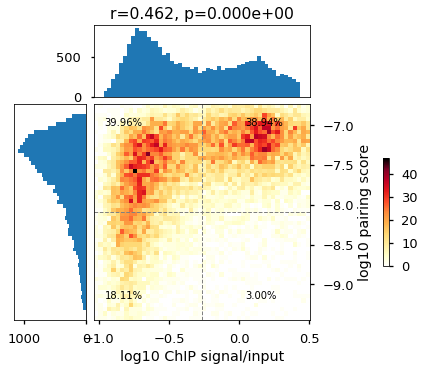

In [10]:
FIG_FOLDER = './pick/your/folder/'

for bw_path in pathlib.Path('/net/levsha/share/lab/DrosophilaWulab/tracks/chip/bigwig/dm3/').glob('*.fc.signal.bw'):
    figname = 'pairing__vs__' + bw_path.name.split('.fc')[0]
    x,y = get_bin_data(bw_path=bw_path, use_chrX=False)
    golden_plot(x,y, show_quadrants=True, x_quadrant=None, y_quadrant=None)

    print(figname)

       
    for fmt in ['.png','.pdf']:
        plt.savefig(
            f'{FIG_FOLDER}/{figname}{fmt}',
            dpi=300,
            bbox_inches = 'tight')
    plt.close()
